In [ ]:
from google.colab import files

up = files.upload()
print(up.keys())


uploaded_name = list(up.keys())[0]
print("Uploaded file name:", uploaded_name)



Saving test.pgm to test (2).pgm
dict_keys(['test (2).pgm'])
Uploaded file name: test (2).pgm


In [ ]:
from PIL import Image
def jpg_to_pgm(input_name, output_name="myinput.pgm"):
    img = Image.open(input_name).convert("L")   # grayscale
    W, H = img.size          # NO resize
    pixels = list(img.getdata())
    with open(output_name, "w") as f:
        f.write("P2\n")
        f.write(f"{W} {H}\n")
        f.write("255\n")
        for i in range(H):
            row = pixels[i*W:(i+1)*W]
            f.write(" ".join(str(p) for p in row) + "\n")
    print(f"Saved {output_name} from {input_name}")

jpg_to_pgm(uploaded_name, "myinput.pgm")


Saved myinput.pgm from test (2).pgm


In [ ]:
10def approximate_sin(angle_deg):
    angle = angle_deg % 360
    # Simple approximations/table for sin
    if angle < 1 or angle > 359:
        return 0.0
    pi_over_180 = 0.0174532925
    a = angle * pi_over_180
    # Taylor: sin ≈ a - a^3/6 + a^5/120 (good < 30°)
    if abs(angle - 90) < 1:
        return 1.0
    if abs(angle - 180) < 1:
        return 0.0
    if abs(angle - 270) < 1:
        return -1.0
    s = a - (a**3)/6 + (a**5)/120
    return max(-1, min(1, s))

def approximate_cos(angle_de1g):
    return approximate_sin(90 - angle_deg)

def matrix_mult(A, B):  # 3x3 * 3x3
    res = [[0.0]*3 for _ in range(3)]
    for i in range(3):
        for j in range(3):
            for k in range(3):
                res[i][j] += A[i][k] * B[k][j]
    return res

def inverse_affine(T):  # Manual 3x3 inverse for affine
    a, b, c = T[0]
    d, e, f = T[1]
    g, h, i = T[2]
    det = a*(e*i - f*h) - b*(d*i - f*g) + c*(d*h - e*g)
    if abs(det) < 1e-6:
        raise ValueError("Singular matrix - bad params")
    inv_det = 1.0 / det
    return [
        [inv_det*(e*i - f*h), inv_det*(c*h - b*i), inv_det*(b*f - c*e)],
        [inv_det*(f*g - d*i), inv_det*(a*i - c*g), inv_det*(c*d - a*f)],
        [inv_det*(d*h - e*g), inv_det*(b*g - a*h), inv_det*(a*e - b*d)]
    ]

def read_pgm(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        if header != 'P2':
            raise ValueError("Not P2 PGM")
        line = f.readline().strip()
        while line.startswith('#'):
            line = f.readline().strip()
        W, H = map(int, line.split())
        maxval = int(f.readline().strip())
        img = []
        for _ in range(H):
            row = list(map(int, f.readline().split()))
            img.append(row)
    print(f"Loaded {H}x{W}, maxval={maxval}")
    return img, H, W, maxval

def write_pgm(filename, img, H, W, maxval):
    with open(filename, 'w') as f:
        f.write('P2\n')
        f.write(f'{W} {H}\n')
        f.write(f'{maxval}\n')
        for row in img:
            f.write(' '.join(map(str, row)) + '\n')
    print(f"Saved {filename}")

def apply_affine(img, H, W, invT, maxval):
    out_img = [[0 for _ in range(W)] for _ in range(H)]
    for i in range(H):
        for j in range(W):
            src_hom = [float(j), float(i), 1.0]
            src_x = 0.0
            src_y = 0.0
            for k in range(3):
                src_x += invT[0][k] * src_hom[k]
                src_y += invT[1][k] * src_hom[k]
            src_xi = max(0, min(W - 1, int(src_x)))
            src_yi = max(0, min(H - 1, int(src_y)))
            out_img[i][j] = img[src_yi][src_xi]
    return out_img


filename = "myinput.pgm"

img, H, W, maxval = read_pgm(filename)

sx  = float(input("Horizontal scaling factor: "))
sy  = float(input("Vertical scaling factor: "))
theta = float(input("Rotation angle (deg): "))
tx  = float(input("Horizontal translation: "))
ty  = float(input("Vertical translation: "))
shx = float(input("Horizontal shear factor: "))
shy = float(input("Vertical shear factor: "))

c = approximate_cos(theta)
s = approximate_sin(theta)

T_scale = [[sx, 0, 0],
           [0, sy, 0],
           [0,  0, 1]]

T_shx = [[1,  shx, 0],
         [0,   1, 0],
         [0,   0, 1]]

T_shy = [[1,   0, 0],
         [shy, 1, 0],
         [0,   0, 1]]

T_rot = [[c, -s, 0],
         [s,  c, 0],
         [0,  0, 1]]

T_trans = [[1, 0, tx],
           [0, 1, ty],
           [0, 0,  1]]

# Compose: T = T_trans * T_rot * T_shy * T_shx * T_scale
T = T_trans
T = matrix_mult(T_rot, T)
T = matrix_mult(T_shy, T)
T = matrix_mult(T_shx, T)
T = matrix_mult(T_scale, T)

invT = inverse_affine(T)

out_img = apply_affine(img, H, W, invT, maxval)
write_pgm('transformed.pgm', out_img, H, W, maxval)
print("✅ Done! Check transformed.pgm")

Loaded 64x64, maxval=255
Horizontal scaling factor: 1.5
Vertical scaling factor: 0.8
Rotation angle (deg): 20
Horizontal translation: 10
Vertical translation: 10
Horizontal shear factor: 0.2
Vertical shear factor: 0.1
Saved transformed.pgm
✅ Done! Check transformed.pgm


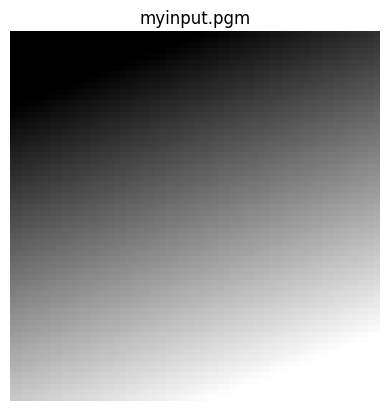

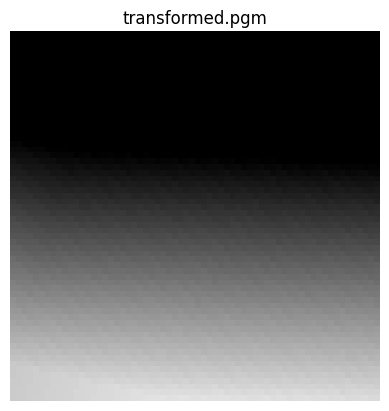

In [ ]:
import matplotlib.pyplot as plt

def show_pgm(filename):
    with open(filename, 'r') as f:
        header = f.readline().strip()
        if header != 'P2':
            raise ValueError("Not P2 PGM")
        line = f.readline().strip()
        while line.startswith('#'):
            line = f.readline().strip()
        W, H = map(int, line.split())
        maxval = int(f.readline().strip())
        img = []
        for _ in range(H):
            row = list(map(int, f.readline().split()))
            img.append(row)
    plt.imshow(img, cmap='gray', vmin=0, vmax=maxval)
    plt.title(filename)
    plt.axis('off')
    plt.show()

# Original
show_pgm("myinput.pgm")


show_pgm("transformed.pgm")